In [2]:
import gym
gym.logger.set_level(40) 
import numpy as np
import copy
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
torch.manual_seed(0) 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import random
from tensorboardX import SummaryWriter

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
env = gym.make('Pendulum-v0').unwrapped
env.seed(2)
n_state=env.observation_space.shape[0]
n_actions=env.action_space.shape[0]
print(f'state space {n_state} \naction space {n_actions}')


state space 3 
action space 1


In [5]:
"""Random Agent"""
Num_episode=10
Time_step=10
def run_episodes(env):
    for episode in range(Num_episode):
        env.reset()
        returns=0
        for t in range(Time_step):
            action=env.action_space.sample()
            next_state,reward,done,_=env.step(action) 
            returns+=reward
            if done:
                print(f"Episode {episode} finished after {t} timesteps")
                break
        print(f"Episode {episode} - total rewards obtained {returns}")
      
run_episodes(env)    

Episode 0 - total rewards obtained -78.26714949640754
Episode 1 - total rewards obtained -35.86170860668216
Episode 2 - total rewards obtained -87.01182758271983
Episode 3 - total rewards obtained -67.92578612447782
Episode 4 - total rewards obtained -0.9287429915697486
Episode 5 - total rewards obtained -82.98560035619047
Episode 6 - total rewards obtained -71.67602700386645
Episode 7 - total rewards obtained -65.60096153395416
Episode 8 - total rewards obtained -58.62458114753926
Episode 9 - total rewards obtained -11.844238830713161


In [6]:
"""Actor _critic network"""
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
"""Experience Replay"""
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
            return len(self.memory)

Ornstein-Uhlenbeck process
<img src="ou.png">

In [8]:
"""Ornstein-Uhlenbeck process."""
class OUNoise:
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

        
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

<img src="ddpg.png">

In [9]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128          # minibatch size
GAMMA = 0.99           # discount factor

TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [10]:
class Agent():
       
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        # Actor Network 
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        # Critic Network
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.fit(experiences, GAMMA)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -2, 2)

    def reset(self):
        self.noise.reset()

    def fit(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        #Crtic update as in DQN 
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        #Actor Update
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean() # As impemented in OpenAI baselines
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
       
    # Target Update
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """ θ_target = τ*θ_local + (1 - τ)*θ_target"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [11]:
def ddpg_network(n_episodes, max_t, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    actin = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            actin.append(action)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            #print(state,action )
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_tmp.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_tmp.pth')
           
    return scores, actin

In [12]:
# Train network
agent = Agent(state_size=n_state, action_size=n_actions, random_seed=121)


In [13]:
Num_episode=150
Time_step=300
scores,actin = ddpg_network(Num_episode,Time_step)

In [12]:
#Evaluation
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_tmp.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_tmp.pth'))
state = env.reset()
actns=[]
stats=[]
rewards=[]
for t in range(400):
    action = agent.act(state, add_noise=False)
    env.render()
    state, reward, done, _ = env.step(action)
    reward+=reward
    actns.append(action)
    stats.append(state)
    rewards.append(reward)
           
env.close()

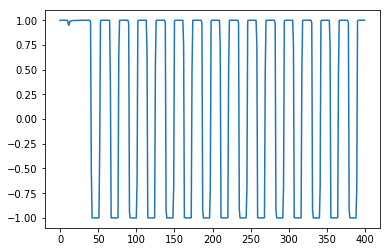

In [13]:
plt.plot(actns)
plt.show()

In [14]:
states = np.stack(stats, axis=0)

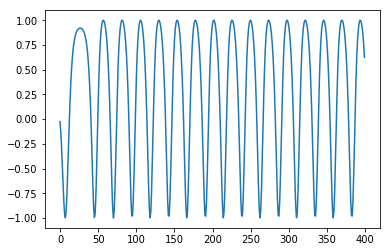

[ 0.99745652  0.97508897  0.92983614  0.85961403  0.76005638  0.62522228
  0.44901796  0.22788471 -0.03680011 -0.34145959 -0.64641506 -0.88819218
 -0.99806921 -0.94016651 -0.7368476  -0.43633781 -0.10072435  0.21815582
  0.48960362  0.69403263  0.83494342  0.92492837  0.97613966  0.99798656
  0.99663397  0.97519702  0.9340874   0.87132219  0.78281975  0.66286925
  0.50512493  0.30462435  0.06109373 -0.22954194 -0.53823755 -0.8100203
 -0.97561791 -0.9811535  -0.82831273 -0.55602808 -0.22483917  0.10679949
  0.39952548  0.63327056  0.79806703  0.9053882   0.96798728  0.99631851
  0.99745715  0.97509102]


In [15]:
plt.plot(states[:,0])
plt.show()
print(states[250:300,0])

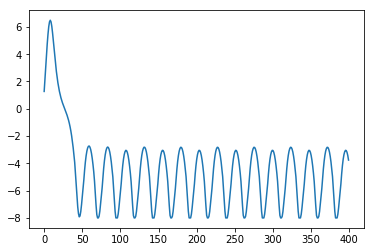

In [16]:
plt.plot(states[:,-1])

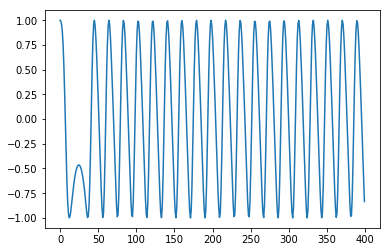

In [17]:
plt.plot(states[:,1])

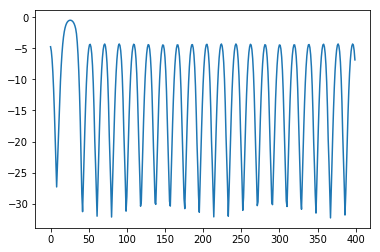

In [19]:
plt.plot(rewards)